In [4]:
!source /opt/xilinx/xrt/setup.sh

Autocomplete enabled for the xbutil command
Autocomplete enabled for the xbmgmt command
XILINX_XRT        : /opt/xilinx/xrt
PATH              : /opt/xilinx/xrt/bin:/home/rforelli/anaconda3/bin:/home/rforelli/anaconda3/condabin:/usr/lib64/qt-3.3/bin:/opt/puppetlabs/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin:/home/rforelli/.local/bin:/home/rforelli/bin
LD_LIBRARY_PATH   : /opt/xilinx/xrt/lib:/opt/xilinx/xrt/lib:
PYTHONPATH        : /opt/xilinx/xrt/python:/opt/xilinx/xrt/python:


In [10]:
import os
import sys
import shutil

%env XILINX_XRT=/opt/xilinx/xrt
%env LD_LIBRARY_PATH=/opt/xilinx/xrt/lib:
%env PYTHONPATH=/opt/xilinx/xrt/python:
#os.environ['PATH'] = '/opt/xilinx/xrt/bin:/home/rforelli/anaconda3/bin:/home/rforelli/anaconda3/condabin:/usr/lib64/qt-3.3/bin:/opt/puppetlabs/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin:/home/rforelli/.local/bin:/home/rforelli/bin:' + os.environ['PATH']

import pynq
import numpy as np

from pynq import allocate
from pynq import Overlay

from matplotlib import pyplot as plt
from datetime import datetime

import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

os.system('mkdir -p ./models/mlp_average_pool_12b/FPGA_model_results')

env: XILINX_XRT=/opt/xilinx/xrt
env: LD_LIBRARY_PATH=/opt/xilinx/xrt/lib:
env: PYTHONPATH=/opt/xilinx/xrt/python:


0

## Deploy Model to Alveo and Run Inference

In [11]:
!/opt/xilinx/xrt/bin/xbutil examine -d 0000:d8:00.1 -r thermal
from pynq import Device
devices = Device.devices
for i in range(len(devices)):
    print("{}) {}".format(i, devices[i].name))

def print_img(matrix, title="Label"):
    plt.imshow(matrix, cmap='magma')
    plt.title(title)
    plt.show()
    
overlay_location='./my-hls-test/axi_stream_driver.py'


-----------------------------------------------
1/1 [0000:d8:00.1] : xilinx_u250_xdma_201830_2
-----------------------------------------------
Thermals
  Temperature            : Celcius
  PCB Top Front          :     40 C
  PCB Top Rear           :     32 C
  PCB Bottom Front       :     39 C
  FPGA                   :     43 C

0) xilinx_u250_xdma_201830_2


In [14]:
# Load the xclbin file to the board
sys.path.append('./models/mlp_average_pool_12b/my-hls-test')
from axi_stream_driver import NeuralNetworkOverlay
ol = NeuralNetworkOverlay(xclbin_name="./models/mlp_average_pool_12b/my-hls-test/xclbin_files/myproject_kernel.xclbin")

# ol.krnl_rtl_1?
# ol.krnl_rtl_1.register_map
# ol.krnl_rtl_1.signature

In [17]:
# Load data
img = np.load("./data/02_scan_x256_y256_raw.npy")

img = np.asarray(img, dtype = np.float32)
img = np.transpose(img,(2,3,0,1)) 
data_r = np.copy(img)
data_r[data_r>1e3]=1e3
min_ = np.min(data_r) 
max_ = np.max(data_r) 
data_r = 1.0*(data_r-min_)/(max_-min_)
data_r = data_r.reshape(-1,1,124,124)
data_r_cut = data_r[:,:,2:122,2:122]
data_r_cut = data_r_cut.reshape(256,256,120,120) 
#data_r_cut = np.rot90(data_r_cut)  
X_test = data_r_cut.reshape(-1, 120,120)
X_test = np.ascontiguousarray(X_test, dtype = np.float32)
#X_test = np.asarray(X_test, dtype = np.float32)

In [18]:
#Allocate memory for data
ol.allocate_mem(X_shape=X_test[0:65536].shape, y_shape=(65536,6), dtype=np.float32)

In [19]:
#Execute inference
y, _, rate = ol.predict(X=X_test[0:65536], y_shape=(65536,6), profile=True, debug=False)

Classified 65536 samples in 18.450436 seconds (3552.0027819396787 inferences / s)
Or 281.53131103515625 us / inferences


In [20]:
#Save prediction results
np.save("./models/mlp_average_pool_12b/FPGA_model_results/y_alveo_inference_results.npy", y)
ol.free_overlay()
print('finished')

finished


## Check Results

In [21]:
# generate outputs/targets
dataset_h5 = h5py.File('./data/unbinned_results.h5','r+')
rots = np.array(dataset_h5['rotation'])
scal = np.array(dataset_h5['scale'])
y = np.concatenate((rots, scal), axis=1)
sc = StandardScaler()
_ = sc.fit(y)
base_8 = np.load('./data/base_8.npy', allow_pickle=1)

predictions = np.load('./models/mlp_average_pool_12b/FPGA_model_results/y_alveo_inference_results.npy')
predictions = sc.inverse_transform(predictions)
predictions.shape
print('FPGA pred: ', predictions[1000])
print('actual:     ', y[1000])

rotation_, scale_ = predictions[:, 0:2], predictions[:, 2:]

mse = np.mean((y - predictions)**2)
print('model MSE on full dataset: ', mse)

FPGA pred:  [0.94416595 0.3251847  1.1280375  0.         0.         1.1984224 ]
actual:      [ 0.99885392 -0.04786232  1.18792486 -0.         -0.          1.14294565]
model MSE on full dataset:  0.011008526892081103


0
1
total activated channels: 2


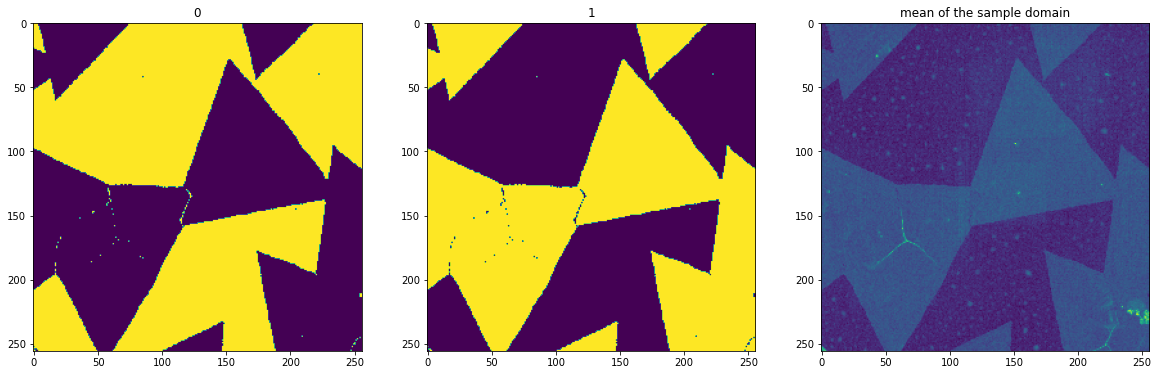

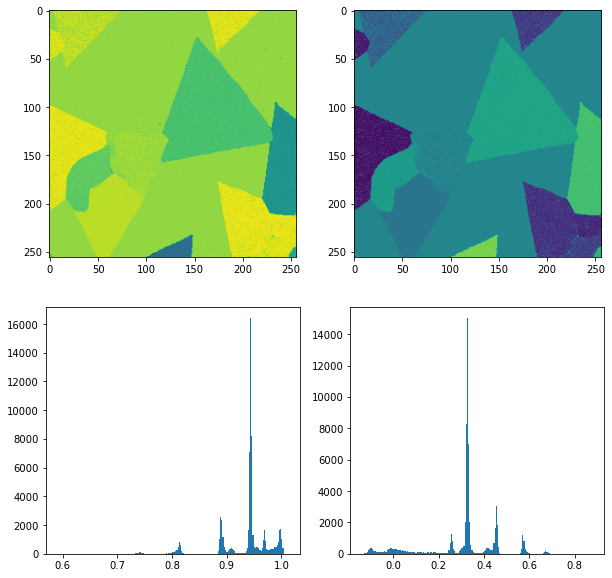

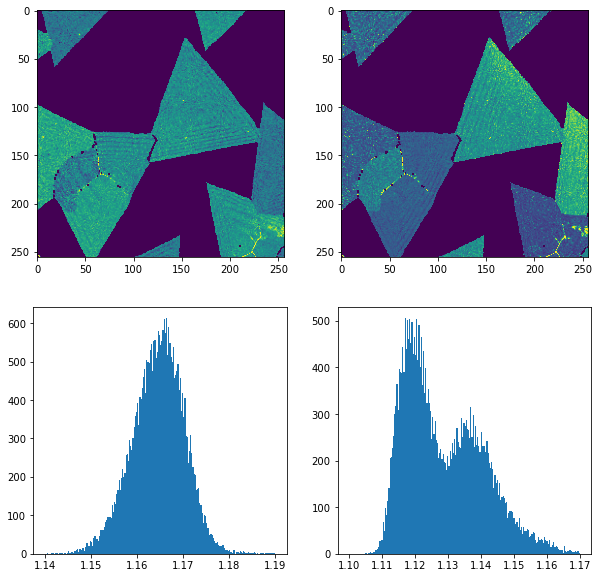

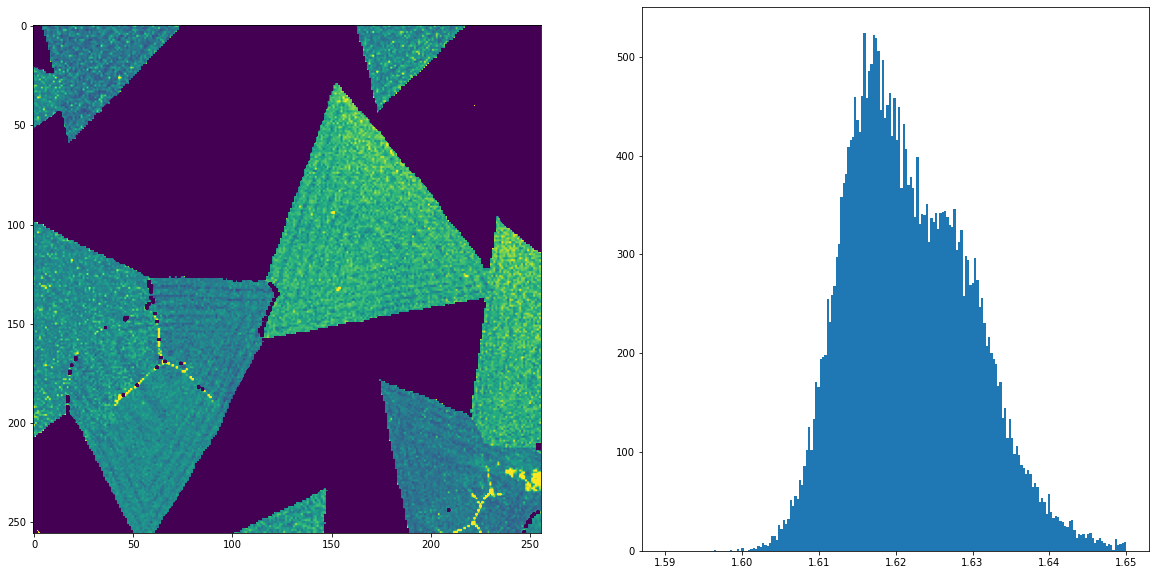

In [24]:
j=0
list_new = []
fig,ax = plt.subplots(1,3,figsize=(20,10))
for i in range(2):
    if np.sum(base_8[:,i]!=0):
        j+=1
        print(i)
        list_new.append(i)
        ax[i].title.set_text(str(i))
        ax[i].imshow(base_8[:,i].reshape(256,256))
print('total activated channels: '+str(j))
ax[2].title.set_text('mean of the sample domain')
ax[2].imshow(np.mean(data_r_cut.reshape(256,256,-1),axis=2))
fig.savefig('./models/mlp_average_pool_12b/FPGA_model_results/fig.png')

fig,ax = plt.subplots(2,2,figsize = (10,10))
ax[0][0].imshow(rotation_[:,0].reshape(256,256))
ax[0][1].imshow(rotation_[:,1].reshape(256,256))
ax[1][0].hist(rotation_[:,0].reshape(-1),200)
ax[1][1].hist(rotation_[:,1].reshape(-1),200)
fig.savefig('./models/mlp_average_pool_12b/FPGA_model_results/rotation.png')

sample_base = base_8[:,1].reshape(256,256)
scale_0 = np.multiply(sample_base.reshape(256,256),scale_[:,0].reshape(256,256))
scale_1 = np.multiply(sample_base.reshape(256,256),scale_[:,3].reshape(256,256))

fig,ax = plt.subplots(2,2,figsize = (10,10))
clim0 = [1.14,1.19]
clim1 = [1.1,1.17]
ax[0][0].imshow(scale_0,clim=clim0)
ax[0][1].imshow(scale_1,clim=clim1)
ax[1][0].hist(scale_0.reshape(-1),200,range=clim0)
ax[1][1].hist(scale_1.reshape(-1),200,range=clim1)
fig.savefig('./models/mlp_average_pool_12b/FPGA_model_results/scale.png')

right_tri = np.sqrt(scale_0**2+scale_1**2).reshape(256,256)
np.save('./models/mlp_average_pool_12b/FPGA_model_results/right_triangle_mlp_average_pool_12b.npy', right_tri)
fig,ax = plt.subplots(1,2,figsize=(20,10))
clim=[1.59,1.65]
ax[0].imshow(right_tri,clim=clim)
ax[1].hist(right_tri.reshape(-1),200,range=clim)
fig.savefig('./models/mlp_average_pool_12b/FPGA_model_results/right_triangle.png')